In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import tarfile

In [3]:
tarfile_path = r"/gdrive/MyDrive/cifar10.tgz"
with tarfile.open(tarfile_path, 'r:gz') as t:
    t.extractall('./data')

In [4]:
import os

In [5]:
os_path = './data/cifar10'
os.listdir(os_path)

['train', 'test']

In [6]:
train_path = os_path + '/train'
test_path = os_path + '/test'

In [7]:
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder

In [8]:
stats = ((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))
train_data_tt = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode = 'reflect'),
                            tt.RandomHorizontalFlip(), tt.ToTensor(),tt.Normalize(*stats)])
test_data_tt = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [9]:
train_ds = ImageFolder(train_path, train_data_tt)
test_ds = ImageFolder(test_path, test_data_tt)

In [10]:
from torch.utils.data import DataLoader

In [11]:
train_dl = DataLoader(train_ds, batch_size=200, shuffle=True,pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=200, pin_memory=True)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class resnet12(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv3t12 = nn.Conv2d(3,12, kernel_size=3, stride=1, padding=1)
        
        self.conv12t48 = nn.Conv2d(12,48, kernel_size=3, stride=1, padding=1)
        
        self.conv48t96 = nn.Conv2d(48,96, kernel_size=3, stride=1, padding=1)
        self.conv96t96a = nn.Conv2d(96,96, kernel_size=3, stride=1, padding=1)
        
        self.conv96t192 = nn.Conv2d(96,192, kernel_size=3, stride=1, padding=1)
        self.conv192t192a = nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        self.conv192t192b = nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        self.conv192t192c = nn.Conv2d(192,192, kernel_size=3, stride=1, padding=1)
        
        self.conv192t384 = nn.Conv2d(192,384,kernel_size=3,stride=1, padding=1)
        self.conv384t384a = nn.Conv2d(384,384, kernel_size=3, stride=1, padding=1)
        self.conv384t384b = nn.Conv2d(384,384, kernel_size=3, stride=1, padding=1)
        self.conv384t384c = nn.Conv2d(384,384, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.norm12 = nn.BatchNorm2d(12)
        self.norm48 = nn.BatchNorm2d(48)
        self.norm96 = nn.BatchNorm2d(96)
        self.norm192 = nn.BatchNorm2d(192)
        self.norm384 = nn.BatchNorm2d(384)
        
        self.relu = nn.ReLU()
        
        self.adpool = nn.AdaptiveAvgPool2d(1) 
        
        # self.drop = nn.Dropout(0.2)
                                         
        self.linear = nn.Linear(384, 10)
        
        self.flat = nn.Flatten()
        
    
    def forward(self,x):
        out = self.conv3t12(x) # 32x 32  12
        out = self.norm12(out)
        out = self.relu(out)
        out = self.conv12t48(out) # 32 x32  48
        out = self.norm48(out)
        out = self.relu(out)
        out = self.pool(out) #16x16  48
        
        out = self.conv48t96(out)  # 16x 16 96
        out = self.norm96(out)
        y = out
        out = self.relu(out)
        out = self.conv96t96a(out) # 16x 16 96
        out= self.relu(out+y)
        out = self.pool(out) # 8x8 96
        
        out = self.conv96t192(out) # 8x8 192
        out = self.norm192(out)
        y = out
        out = self.relu(out)
        out = self.conv192t192a(out)
        out = self.relu(out+y)
        out = self.conv192t192b(out)
        out = self.relu(out+y)
        out = self.conv192t192c(out)
        out = self.relu(out+y)
        
        out = self.conv192t384(out)
        out = self.norm384(out)
        y = out
        out = self.relu(out)
        out = self.conv384t384a(out)
        out = self.relu(out+y)
        out = self.conv384t384b(out)
        out = self.relu(out+y)
        out = self.conv384t384c(out)
        out = self.relu(out)
        
        
        out = self.adpool(out)
        out = self.flat(out)
        # out = self.drop(out)
        out = self.linear(out)
        # out = torch.softmax(out, dim=-1)
        
        return out


In [23]:
model = resnet12()

In [20]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [26]:
data = DataBunch.create(train_ds,valid_ds=test_ds, bs=200, path='./data/cifar10')
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1
learner.fit_one_cycle(20,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.181036,0.319379,0.899300,00:53
1,0.182017,0.362435,0.892200,00:53
2,0.227153,0.373929,0.880500,00:52
3,0.265192,0.440050,0.863600,00:53
4,0.294153,0.487105,0.844400,00:53
5,0.297262,0.560754,0.832500,00:52
6,0.295943,0.421338,0.865600,00:53
7,0.281501,0.443382,0.863900,00:53
8,0.252355,0.446264,0.861900,00:53
9,0.233744,0.392871,0.876400,00:52


In [27]:
torch.save(model.state_dict(), '/gdrive/MyDrive/cifar10resnet.pth')

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
model.to(device)

resnet12(
  (conv3t12): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12t48): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv48t96): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv96t96a): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv96t192): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv192t192a): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv192t192b): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv192t192c): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv192t384): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv384t384a): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv384t384b): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv384t384c): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
# import numpy as np
# num_epochs = 100
# loss_func = nn.BCELoss()
# opt_func = torch.optim.Adam(model.parameters(), lr=1e-3)

# for epoch in range(num_epochs):
    
#     for i,l in train_dl:

#         res = []
        
#         for _ in l:
#             z = np.zeros(10)
#             z[int(_)] = 1
#             res.append(z.astype(np.float32))
        
#         i = i.to(device)
        
#         pred = model(i)
        
#         res = torch.Tensor(res)
#         res = res.to(device)
        
#         loss = loss_func(pred.to(device), res)
#         loss.backward()
        
#         opt_func.step()
#         opt_func.zero_grad()
    
#     with torch.no_grad():
#         x = 0
#         for i,l in test_dl:
#             i = i.to(device)
#             preds_ = model(i)
#             for j in range(len(preds_)):
#                 if preds_[j].max()==preds_[j][l[j].item()]:
#                     x += 1
#         accuracy = x/len(test_ds)
#         print(f'{accuracy*100}, {epoch+1}, {loss}')

In [56]:
import matplotlib.pyplot as plt
import cv2

In [70]:
def pred(path):
    q = path
    img = cv2.imread(q, 1)
    plt.imshow(img)
    img = cv2.resize(img, (32,32))
    img_arr = np.asarray(img).astype(np.float32)
    img_tensor = torch.Tensor(img_arr)
    img_tensor = img_tensor/255
    img_tensor = img_tensor.permute(2,0,1)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    pred = model(img_tensor)
    _,pred = torch.max(pred, dim=1)
    print(train_ds.classes[pred[0].item()])

deer


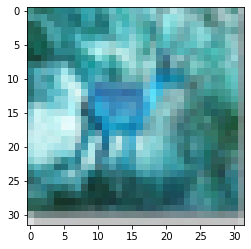

In [79]:
pred(r'/content/data/cifar10/test/deer/0041.png')